In [13]:
using HDF5; h5 = HDF5
using PyPlot; plt = PyPlot

#fid = h5.h5open("beta20/gf_ysr.order2_ntau1024_N_samples1024_N_seqs4.h5", "r")
#fid = h5.h5open("gf_ysr.order2_ntau256_N_samples256_N_seqs4.h5", "r")
#fid = h5.h5open("gf_ysr.order2_ntau1024_N_samples256_N_seqs4.h5", "r")
fid = h5.h5open("gf_ysr.order2_ntau1024_N_samples65536_N_seqs4.h5", "r")

τ = fid["/data/tau"][]
@show β = τ[end]

orders = fid["/data/orders"][]
@show orders

g_u1 = imag(fid["/data/gf/up_11"][]);
g_d1 = imag(fid["/data/gf/dn_11"][]);
g_u2 = imag(fid["/data/gf/up_22"][]);
g_d2 = imag(fid["/data/gf/dn_22"][]);

g_std_u1 = fid["/data/gf_std/up_11"][];
g_std_d1 = fid["/data/gf_std/dn_11"][];
g_std_u2 = fid["/data/gf_std/up_22"][];
g_std_d2 = fid["/data/gf_std/dn_22"][];

β = τ[end] = 20.0
orders = [0, 1, 2]


# Fit of the exponential slopes of $G(\tau)$

In [73]:
using LsqFit

function fit_slope(τ, g_τ, τ_fit_min, τ_fit_max, ϵ0)
    @. model(τ, p) = p[1] + p[2] * exp(-τ * p[3])
    fit_range = findfirst(t -> t>=τ_fit_min, τ):findlast(t -> t<=τ_fit_max, τ)
    τ_fit = τ[fit_range]
    fit = curve_fit(model, τ_fit, -g_τ[fit_range], [0.0, 1.0, ϵ0])
    return τ_fit, model(τ[fit_range], coef(fit)), coef(fit)[3]
end

fit_slope (generic function with 2 methods)

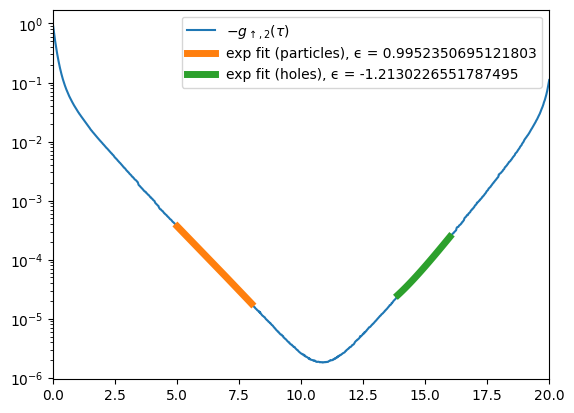

PyObject <matplotlib.legend.Legend object at 0x7f0b9594ec90>

In [101]:
g_τ = g_u2
plt.semilogy(τ, -g_τ, label=raw"$-g_{\uparrow,2}(\tau)$")

fit_τ_p, fit_p, ϵ_p = fit_slope(τ, g_τ, 5.0, 8.0, 1.0)
plt.semilogy(fit_τ_p, fit_p, lw=5, label="exp fit (particles), ϵ = $(ϵ_p)")
fit_τ_m, fit_m, ϵ_m = fit_slope(τ, g_τ, 13.9, 16.0, -1.1)
plt.semilogy(fit_τ_m, fit_m, lw=5, label="exp fit (holes), ϵ = $(ϵ_m)")
plt.xlim((0, β))
plt.legend()

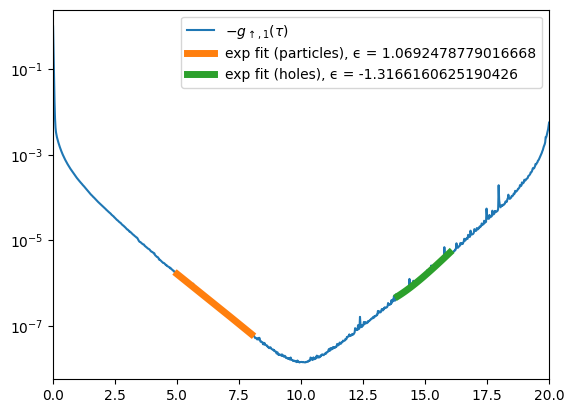

PyObject <matplotlib.legend.Legend object at 0x7f0b95b94ad0>

In [100]:
g_τ = g_u1
plt.semilogy(τ, -g_τ, label=raw"$-g_{\uparrow,1}(\tau)$")

fit_τ_p, fit_p, ϵ_p = fit_slope(τ, g_τ, 5.0, 8.0, 1.0)
plt.semilogy(fit_τ_p, fit_p, lw=5, label="exp fit (particles), ϵ = $(ϵ_p)")
fit_τ_m, fit_m, ϵ_m = fit_slope(τ, g_τ, 13.9, 16.0, -1.0)
plt.semilogy(fit_τ_m, fit_m, lw=5, label="exp fit (holes), ϵ = $(ϵ_m)")
plt.xlim((0, β))
plt.legend()

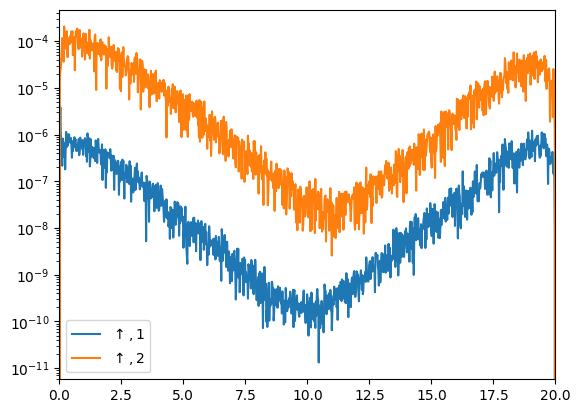

PyObject <matplotlib.legend.Legend object at 0x7f0b9f855490>

In [38]:
plt.semilogy(τ, abs.(real(g_std_u1)), label=raw"$\uparrow,1$")
plt.semilogy(τ, abs.(real(g_std_u2)), label=raw"$\uparrow,2$")
#plt.semilogy(τ, abs.(real(g_std_d1)), label=raw"$\donwarrow,1$")
#plt.semilogy(τ, abs.(real(g_std_d2)), label=raw"$\downarrow,2$")
plt.xlim((0, β));
plt.legend()

# Gregory integration

In [4]:
raw"""
Compute a list of Gregory coefficients G_1, G_2, ..., G_{n_max}
using a recurrence formula

\frac{G_1}{n} - \frac{G_2}{n-1} + \frac{G_3}{n-2} - ... +
    + (-1)^{n-1}\frac{G_n}{1} = \frac{1}{n+1}.
"""
function gregory_coefficients(n_max)
    @assert n_max >= 1

    G = [0.5]
    for n in 2:n_max
        s = sum((-1) ^ (i - 1) / (n + 1 - i) * G[i] for i in 1:(n - 1))
        G_n = (-1) ^ (n - 1) * (1 / (n + 1) - s)
        push!(G, G_n)
    end

    return G
end

"Returns weights for Gregory integration"
function gregory_weights(n, order)
    stencil_size = order + 1
    @assert n > stencil_size

    # Trapezoid rule contribution
    w = ones(Float64, n)
    w[1] = w[end] = 0.5

    # Gregory boundary corrections
    if order > 0
        G = gregory_coefficients(order + 1)
        B = [sum(G[r] * (-1) ^ (r - i) * binomial(r - 1, i) for r in 2:(order + 1)) for i in 0:order]
        w[1:stencil_size] += B
        w[end-stencil_size+1:end] += B[end:-1:1]
    end
    
    return w
end

gregory_weights

# Fourier transform

In [5]:
using Interpolations
using QuadGK

function fourier(τ_list, g_τ, n_iω)
    β = τ_list[end]
    Δτ = step(τ_list)
    g_τ_itp = scale(interpolate(g_τ, BSpline(Cubic(Line(OnGrid())))), τ_list)
    g_iω = zeros(ComplexF64, 2n_iω)
    for n in -n_iω:(n_iω-1)
        ω = π * (2n + 1) / β
        g_iω[n+n_iω+1] = quadgk(τ -> g_τ_itp(τ) * exp(1im * ω * τ), 0, β, atol=1e-13)[1]
    end
    return g_iω
end

fourier (generic function with 1 method)

Test using a model function

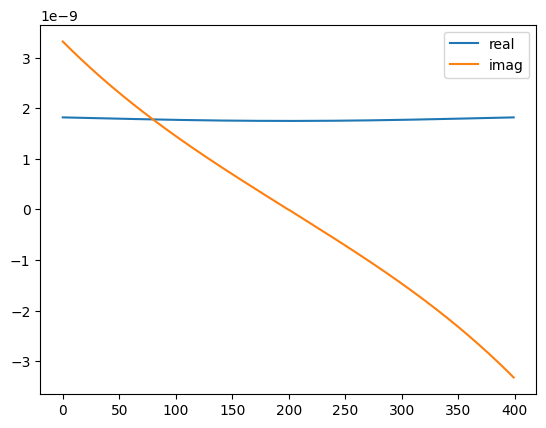

PyObject <matplotlib.legend.Legend object at 0x7f0bbc3ea450>

In [6]:
n_τ = 1024
β = 10

poles = (1.0, -1.0, 0.5, -0.5)
weights = (3/32, 5/32, 11/32, 13/32)
@assert sum(weights) == 1

f(ϵ) = 1 / (1 + exp(-β * ϵ))

τ_list = range(0, β, n_τ)
g_τ_test = -[sum(w * exp(-τ * ϵ) * f(ϵ) for (ϵ, w) in zip(poles, weights)) for τ in τ_list]
@assert g_τ_test[1] + g_τ_test[end] == -1

n_iω = 200
g_iω_test = fourier(τ_list, g_τ_test, n_iω)

g_iω_ref = [sum(w / ((1im * π * (2n+1) / β) - ϵ) for (ϵ, w) in zip(poles, weights))
            for n in -n_iω:(n_iω-1)]

plt.plot(real.(g_iω_test - g_iω_ref), label="real")
plt.plot(imag.(g_iω_test - g_iω_ref), label="imag")
plt.legend()

# Analytic continuation

In [7]:
using BaryRational
using QuadGK
using LinearAlgebra: norm, diag

"Norm of a spectral function"
function dos_norm(ϵ_list, ρ)
    ρ_itp = scale(interpolate(ρ, BSpline(Cubic(Line(OnGrid())))), ϵ_list)
    return quadgk(ρ_itp, ϵ_list[1], ϵ_list[end], atol=1e-13)[1]
end

function cont(τ_list, g_τ, n_iω, ϵ_list, δ)
    println("Discontinous jump: $(-g_τ[1]-g_τ[end])")
    β = τ_list[end]
    
    iω = 1im * [π * (2n + 1) / β for n in -n_iω:(n_iω-1)]
    g_iω = fourier(τ_list, g_τ, n_iω)

    setprecision(BigFloat, 256)

    # Construct Pade approximant
    N = 2n_iω
    g = zeros(Complex{BigFloat}, N, N)
    g[1, :] = g_iω

    for p in 1:(N-1)
        # If |g| is very small, the continued fraction should be truncated.
        norm(g[p, p]) < 1e-20 && break

        for j in p:(N-1)
            x = g[p, p] / g[p, j + 1] - 1
            y = iω[j + 1] - iω[p]
            g[p + 1, j + 1] = x / y
        end
    end
    a = diag(g) # Pade coefficients

    # Evaluate the approximant at real frequencies
    ρ = zeros(Float64, length(ϵ_list))

    for (n, ϵ) in enumerate(ϵ_list)
        A1::Complex{BigFloat} = 0
        A2 = a[1]
        B1::Complex{BigFloat} = 1
        
        for i in 0:(N-2)
            Anew = A2 + (ϵ + 1im*δ - iω[i + 1]) * a[i + 2] * A1
            Bnew = 1.0 + (ϵ + 1im*δ - iω[i + 1]) * a[i + 2] * B1
            A1 = A2 / Bnew
            A2 = Anew / Bnew
            B1 = 1.0 / Bnew
        end
        ρ[n] = -(1 / π) * imag(A2)
    end
    
    return ρ
end

function reconstruct(ρ, ϵ_list, τ_list)
    ρ_itp = scale(interpolate(ρ, BSpline(Cubic(Line(OnGrid())))), ϵ_list)
    g_τ = Vector{Float64}(undef, length(τ_list))

    β = τ_list[end]
    
    for (j, τ) in enumerate(τ_list)
        K(τ, ϵ) = -(ϵ > 0 ? exp(-τ * ϵ) / (1 + exp(-β * ϵ)) : exp((β-τ) * ϵ) / (1 + exp(β * ϵ)))
        g_τ[j] = quadgk(ϵ -> K(τ, ϵ) * ρ_itp(ϵ), ϵ_list[1], ϵ_list[end], atol=1e-13)[1]
    end

    return g_τ
end

reconstruct (generic function with 1 method)

Discontinous jump: 0.9999999999999999
DOS norm: 0.981410772033897
Max discrepancy: 0.09018698603551789


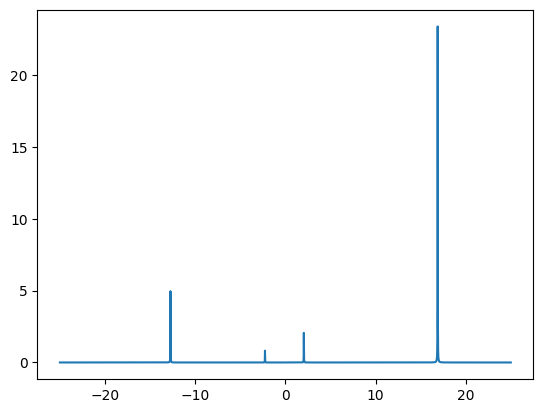

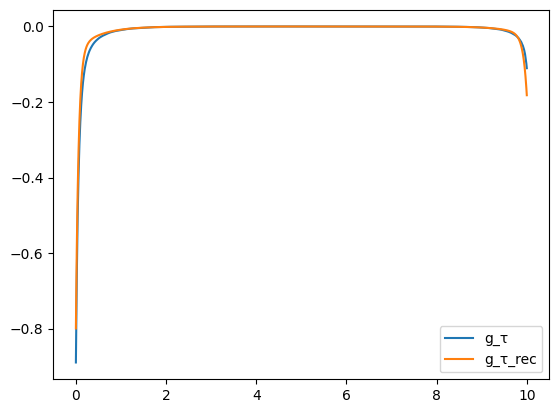

In [11]:
n_iω = 30
ϵ_list = -25:0.001:25
δ = 0.01

τ_list = range(0, β, length(g_u2))

ρ = cont(τ_list, g_u2, n_iω, ϵ_list, δ)

println("DOS norm: ", dos_norm(ϵ_list, ρ))
plt.plot(ϵ_list, ρ);

g_rec = reconstruct(ρ, ϵ_list, τ_list)

plt.figure()
plt.plot(τ_list, g_u2, label="g_τ")
plt.plot(τ_list, g_rec, label="g_τ_rec")
plt.legend()
println("Max discrepancy: ", maximum(abs.(g_u2 - g_rec)))